# Deep Learning project - Caract Classification

Group 7:
* Lorenzo Benatti
* Davide de Crescenzo
* Matilde Farci
* Federico Muraro
* Davide Sabbadin

# Abstract

**Description of the original project**:
[The project](https://www.kaggle.com/code/koshirosato/cataract-classification-with-two-retina-datasets/notebook) we assessed aims at classifying cataracts from eye fundus images.

Data was pooled from two datasets, the first containing only eye images divided into four classes (no additional information was provided) coming from an unknown source, while the second (curated by Shandong Medical Technologies) contained a set of two images (both eyes) for each patient, along with related text diagnoses.

Images were divided into training and test set taking into account class balance, and then resized. Two models were trained (the first with custom architecture while the second based on transfer learning).
We assessed the code and report here our findings and possible improvements.

**Original project limitations**:
* No preprocessing was performed
* Models were lengthy to train(>7 seconds/epochs)
* Only a subset of the dataset was used due to class imbalance issues
* Use of deprecated functions
* Images from the two datasets were pooled but classified with different criteria
* Leakage of information due to the use of images from the same person both in training and test set	(data leakage)
* Dataset limitations: low quality images and few cataract ones

**Objective**:
After having assessed the possible weak spots of the original notebook, we set out to mitigate the aforementioned limitations.

**Methods**:
Since we noticed some inconsistencies in the way datasets were split that lead to data leakage, we decided to split data differently and to also use a bigger portion of the second dataset.
Bibliographic research and preliminary data analysis were conducted; this lead us to standardize image size, to reduce the borders around the fundus image, and to apply CLAHE on grayscale images. Structural flaws in the models were also fixed.

**Results**:
We achieved more robust models that classify cataracts from images of eyes affected by other pathologies and not only healthy ones. We also corrected several inconsistencies and in general, we tried to use the knowledge acquired during the lectures to obtain better models.

# Contents


>[Abstract](#scrollTo=7NIQ0zWeEa9i)

>[Contents](#scrollTo=dD6ICjL2FH9s)

>[Import libraries](#scrollTo=Ul28Hm5KGoVE)

>[Set seed](#scrollTo=neTV6XlJVgSX)

>[Set configurations](#scrollTo=e9FnNIACItM2)

>[Dataset 1 - preprocessing](#scrollTo=8_NKXLuiJQLP)

>[Dataset 2 - preprocessing](#scrollTo=QNupKsEXWmPq)

>>[Original Kaggle code](#scrollTo=leGM9l74aO-5)

>>[Group project version](#scrollTo=IcFCEOzmcBrN)

>[Create dataframes](#scrollTo=XEZA16-iWqWF)

>>[Original Kaggle code](#scrollTo=D2lhs3nMdnRy)

>>[Group project version](#scrollTo=EdNAZCGIeJwj)

>>>[Dataset 1 - Splitting](#scrollTo=fya5lXN0kZTb)

>>>[Dataset 2 - Downsampling & splitting](#scrollTo=_tePx6rjkmS1)

>>>[Concatenation - Dataset 1 & Dataset 2](#scrollTo=ut88QtCH0j_h)

>[Exploratory Data Analysis](#scrollTo=aECb4ah9srJf)

>[Images preprocessing and dataset creation](#scrollTo=zIhiOJKA26SQ)

>>[Results](#scrollTo=9AsbbNqKgCC_)

>[Definiton of the customized CNN model](#scrollTo=KFSF7HqX7A6S)

>>[Original Kaggle model](#scrollTo=7zE5dO7m3ZRF)

>>[Group project version](#scrollTo=eBl66YZfgtBF)

>>>[Results](#scrollTo=ZKDfAEbgBpUn)

>[Definition of EfficientNet based model](#scrollTo=IQlhbp3esDxD)

>>[Original Kaggle model](#scrollTo=NfS1rXsKGptU)

>>[Group project version](#scrollTo=hIFtW3d3hLJT)

>>>[Results](#scrollTo=Phdh8XegjKe4)

>[Conclusion](#scrollTo=ho4N6OwECfW7)



# Import libraries

In order to download Kaggle datasets in the Colab envirroment a Kaggle API file is required: Kaggle > Profile > Account > Download API

In [1]:
# Downloading the two datasets from Kaggle

! pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"matildef","key":"110c03be050e75595eeca2f2f975ac22"}'}

In [2]:
import zipfile

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Datasets download
! kaggle datasets download -d jr2ngb/cataractdataset
! kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
zip_ref = zipfile.ZipFile('cataractdataset.zip', 'r')
# Unzip
zip_ref.extractall('/content/cataractdataset')
zip_ref.close()
zip_ref = zipfile.ZipFile('ocular-disease-recognition-odir5k.zip', 'r')
# Unzip to
zip_ref.extractall('/content/ocular-disease-recognition-odir5k')
zip_ref.close()


100% 3.34G/3.34G [01:38<00:00, 38.8MB/s]
100% 3.34G/3.34G [01:38<00:00, 36.5MB/s]
100% 1.62G/1.62G [00:41<00:00, 44.5MB/s]
100% 1.62G/1.62G [00:41<00:00, 42.2MB/s]


In [3]:
!pip install -q efficientnet >> /dev/null

In [4]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, balanced_accuracy_score, roc_auc_score, roc_curve
import seaborn as sns
from scipy import ndimage

from skimage.io import imread
from skimage import io
from skimage.color import rgb2gray
import imageio
import skimage

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import *

# Set seed

In [5]:
SEED = 52

# Setting seed for reproducibility
# Each library uses their own pseudorandom number generator
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

# Set configurations

In the original code images were resized to 256 x 192 pixels, whereas we resized them to 256 x 256 pixels (see the sections *Images preprocessing and dataset creation, Definition of EfficientNet based model*).

In [6]:
EPOCHS = 100
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256

rcParams['font.size'] = 14
sns.set(font_scale=1.5, style='white')

# Dataset 1 - preprocessing

The first dataset was created from four folders, each one corresponding to a different diagnosis (normal fundus, cataract, glaucoma, retinal disease), and no other information was provided regarding the patient.

In the original project only normal fundus and cataract images were taken into account; we decided to consider all four diagnoses, but to merge all non-cataract ones, therefore obtaining two classes:
* cataract
* non-cataract (normal fundus, glaucoma, retinal disease)

In [7]:
# Dataset 1
IMG_ROOT = '/content/cataractdataset/dataset/'
IMG_DIR = [IMG_ROOT+'1_normal',
           IMG_ROOT+'2_cataract',
           IMG_ROOT+'2_glaucoma',
           IMG_ROOT+'3_retina_disease']

# Initializing the dataframe
df_1 = pd.DataFrame(0,
                  columns=['paths',
                           'cataract'],
                  index=range(601)) # 601 = #imgs in dataset 1

# glob.glob() returns a possibly empty list of path names that match IMG_ROOT*/*
filepaths = glob.glob(IMG_ROOT + '*/*')




---



---



Let's see the distribution of the diagnoses in the first dataset, even though we classify all the other diseases and normal images as non-cataract:

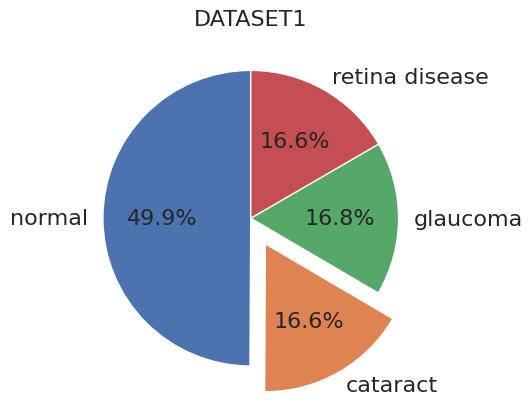

In [8]:
# Sample data
labels = ['normal', 'cataract', 'glaucoma', 'retina disease']
sizes = [len(os.listdir('/content/cataractdataset/dataset/1_normal')),
         len(os.listdir('/content/cataractdataset/dataset/2_cataract')),
         len(os.listdir('/content/cataractdataset/dataset/2_glaucoma')),
         len(os.listdir('/content/cataractdataset/dataset/3_retina_disease'))]
myexplode = [0, 0.2, 0, 0]

# Plotting the pie chart
plt.pie(sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        explode = myexplode,
        textprops={'fontsize': 16})

# Title of the pie chart
plt.title('DATASET1', fontsize = 16)

# Display the pie chart
plt.show()



---



---



In [9]:
# Create a dataframe containing:
# 1st column -> image path
# 2nd column -> image class (0->non-cataract, 1->cataract)
for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    df_1.iloc[i, 0] = filepath[0] + '/' + filepath[1]

    if filepath[0] == IMG_DIR[0]:    # normal
        df_1.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[1]:  # cataract
        df_1.iloc[i, 1] = 1
    elif filepath[0] == IMG_DIR[2]:  # glaucoma
        df_1.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[3]:  # retina_disease
        df_1.iloc[i, 1] = 0

The classes are unbalanced, but this problem will be tackled later:

In [10]:
print('Number of normal and cataract images')
print(df_1['cataract'].value_counts())

Number of normal and cataract images
0    501
1    100
Name: cataract, dtype: int64


# Dataset 2 - preprocessing

The second dataset was created from a .xlsx file which reported, for each patient, the paths of their two fundus images (left and right eye) and the corresponding diagnoses, one for each eye; the diagnosis is written in a text field and it's not categorical per se, rather each image can be associated with multiple diagnoses.

## Original Kaggle code

After loading the dataset, a simple text search is implemented to label both eyes images: two dataframes are created, one for each eye. Since there is a large bias in both dataframes, a downsampling is performed (the same number of cataract and non-cataract images is extracted). Finally, the two dataframes are then concatenated.

In [11]:
# OCU_IMG_ROOT = '../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/'
# ocu_df = pd.read_excel('../input/ocular-disease-recognition-odir5k/ODIR-5K/data.xlsx')
# ocu_df.head()

# def has_cataract_mentioned(text):
#     if 'cataract' in text:
#         return 1
#     else:
#         return 0

# ocu_df['left_eye_cataract'] = ocu_df['Left-Diagnostic Keywords']\
#                                  .apply(lambda x: has_cataract_mentioned(x))
# ocu_df['right_eye_cataract'] = ocu_df['Right-Diagnostic Keywords']\
#                                  .apply(lambda x: has_cataract_mentioned(x))

#  le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_cataract']]\
#         .rename(columns={'left_eye_cataract':'cataract'})
# le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
# le_df = le_df.drop('Left-Fundus', axis=1)


# re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_cataract']]\
#         .rename(columns={'right_eye_cataract':'cataract'})
# re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
# re_df = re_df.drop('Right-Fundus', axis=1)

# le_df.head()
# re_df.head()

# print('Number of left eye images')
# print(le_df['cataract'].value_counts())
# print('\nNumber of right eye images')
# print(re_df['cataract'].value_counts())

# def downsample(df):
#     df = pd.concat([
#         df.query('cataract==1'),
#         df.query('cataract==0').sample(sum(df['cataract']),
#                                        random_state=SEED)
#     ])
#     return df


# le_df = downsample(le_df)
# re_df = downsample(re_df)

# print('Number of left eye images')
# print(le_df['cataract'].value_counts())
# print('\nNumber of right eye images')
# print(re_df['cataract'].value_counts())



# ocu_df = pd.concat([le_df, re_df])
# ocu_df.head()


## Group project version

In [12]:
# Dataset 2
OCU_IMG_ROOT = '/content/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/'
df_2 = pd.read_excel('/content/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/data.xlsx')

df_2.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


A simple text search was implemented in the original code to label every image as either cataract or non-cataract:

In [13]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0

# Create two additional columns (left and right eye):
# 0->non-cataract
# 1->cataract)

df_2['left_eye_cataract'] = df_2['Left-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))

df_2['right_eye_cataract'] = df_2['Right-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))

df_2.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,left_eye_cataract,right_eye_cataract
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,1,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,0,0
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1,0,0
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,0,0




---
---





Let's see the distribution of the diagnoses in the second dataset dataset, even though we classify all the other diseases and normal images as non-cataract:

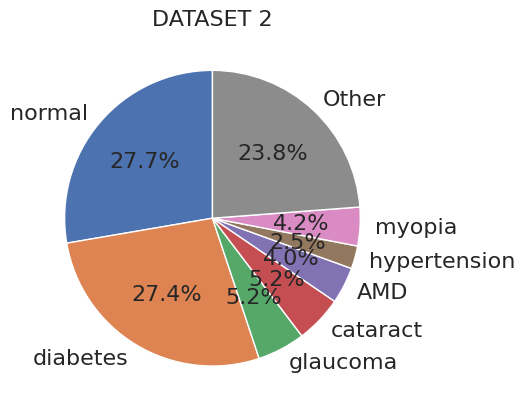

In [14]:
N = df_2['N'].sum()
D = df_2['D'].sum()
G = df_2['G'].sum()
C = df_2['C'].sum()
A = df_2['A'].sum()
H = df_2['H'].sum()
M = df_2['M'].sum()
O = df_2['O'].sum()


# Sample data
labels = ['normal', 'diabetes', 'glaucoma', 'cataract', 'AMD', 'hypertension', 'myopia', 'Other']
sizes = [N, D, G, C, A, H, M, O]
myexplode = [0, 0, 0, 0, 0, 0, 0, 0]


# Plotting the pie chart
plt.pie(sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        explode = myexplode,
        textprops={'fontsize': 16})

# Title of the pie chart
plt.title('DATASET 2', fontsize = 16)

# Display the pie chart
plt.show()

We can also notice that some patients have more than one disease:

Patients with >2 diseases
586
Patients with 1 disease
1774


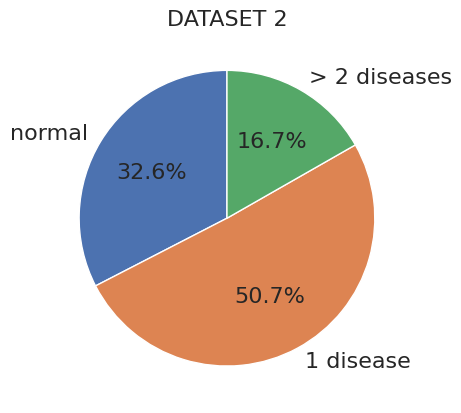

In [15]:
df_2[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']]
num_columns_with_two_ones = (df_2[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum(axis=1) >= 2).sum()

print('Patients with >2 diseases')
print(num_columns_with_two_ones)
only_one_one = (df_2[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum(axis=1) == 1).sum() - df_2['N'].sum()
print('Patients with 1 disease')
print(only_one_one)

# Sample data
labels = ['normal', '1 disease', '> 2 diseases']
sizes = [df_2['N'].sum(), only_one_one, num_columns_with_two_ones]

# Plotting the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 16})

# Title of the pie chart
plt.title('DATASET 2', fontsize = 16)

# Display the pie chart
plt.show()



---



---



In the original project the possible correlation between the left and right eye fundus images of the same patient wasn't taken into account,
thus leading to a possible correlation between training and test set (e.g. the left eye and right eye images of the same patients were possibly split between the training and test set).
We choose, therefore, to split data over patients rather than images, in order to have a subset of patients only present in the training set, and another set of patients present only in the test set:
* if both eyes are labeled as cataract, both of them are put in one of the sets (either training, test, or validation)
* if only one eye is labeled as cataract only that one is put in one of the sets
* if both eyes are non-cataract, only one of them is selected

In [16]:
# Creating a dataframe in which row = [left eye img, left eye label, right eye img, right eye label]
df_2_subjs = df_2.loc[:, ['Left-Fundus', 'left_eye_cataract', 'Right-Fundus', 'right_eye_cataract']]
df_2_subjs['Left-Fundus'] = OCU_IMG_ROOT + df_2_subjs['Left-Fundus']
df_2_subjs['Right-Fundus'] = OCU_IMG_ROOT + df_2_subjs['Right-Fundus']
df_2_subjs.head()

,Left-Fundus,left_eye_cataract,Right-Fundus,right_eye_cataract
0,/content/ocular-disease-recognition-odir5k/ODI...,1,/content/ocular-disease-recognition-odir5k/ODI...,0
1,/content/ocular-disease-recognition-odir5k/ODI...,0,/content/ocular-disease-recognition-odir5k/ODI...,0
2,/content/ocular-disease-recognition-odir5k/ODI...,0,/content/ocular-disease-recognition-odir5k/ODI...,0
3,/content/ocular-disease-recognition-odir5k/ODI...,0,/content/ocular-disease-recognition-odir5k/ODI...,0
4,/content/ocular-disease-recognition-odir5k/ODI...,0,/content/ocular-disease-recognition-odir5k/ODI...,0


The classes are unbalanced, but this problem will be tackled later:

In [17]:
print('Total number of images in the 2nd dataset')
print((df_2_subjs['left_eye_cataract'].value_counts() + df_2_subjs['right_eye_cataract'].value_counts()))
print()
print('Total number of left eye cataract images in the 2nd dataset')
print(sum(df_2_subjs['left_eye_cataract']==1))
print('Total number of right eye cataract images in the 2nd dataset')
print(sum(df_2_subjs['right_eye_cataract']==1))

Total number of images in the 2nd dataset
0    6687
1     313
dtype: int64

Total number of left eye cataract images in the 2nd dataset
159
Total number of right eye cataract images in the 2nd dataset
154


# Create dataframes

##  Original Kaggle code


In the original project, the final dataframe is the concatenation of the two dataframes originating from the two datasets. This final dataframe is split into training, validation, test set.

In [18]:
# df = pd.concat([cat_df, ocu_df], ignore_index=True)
# df

# train_df, test_df = train_test_split(df,
#                                      test_size=0.2,
#                                      random_state=SEED,
#                                      stratify=df['cataract'])

# train_df, val_df = train_test_split(train_df,
#                                     test_size=0.15,
#                                     random_state=SEED,
#                                     stratify=train_df['cataract'])

## Group project version

With respect to the original project, we perform the splitting separately on the two datasets; we need to do so due to the different structures of the two dataframes `df_1` and `df_2` (see the end of the section *Dataset 2 - preprocessing* for an explanation of `df_2` structure).

### Dataset 1 - Splitting

We need to split the first dataset into training, validation, and test sets.

In [19]:
# Split dataframe in a stratified way (equal class distribution in the sets)
train_1, test_1 = train_test_split(df_1,
                                     test_size=0.2,
                                     random_state=SEED,
                                     stratify=df_1[['cataract']])

train_1, val_1 = train_test_split(train_1,
                                     test_size=0.15,
                                     random_state=SEED,
                                     stratify=train_1[['cataract']])

print('Total number of images in training set (1st dataset)')
print(train_1['cataract'].value_counts())
print()
print('Total number of images in test set (1st dataset)')
print(test_1['cataract'].value_counts())
print()
print('Total number of images in validation set (1st dataset)')
print(val_1['cataract'].value_counts())

Total number of images in training set (1st dataset)
0    340
1     68
Name: cataract, dtype: int64

Total number of images in test set (1st dataset)
0    101
1     20
Name: cataract, dtype: int64

Total number of images in validation set (1st dataset)
0    60
1    12
Name: cataract, dtype: int64


### Dataset 2 - Downsampling & splitting

Due to the aforementioned reasons, we chose to split data over patients rather than images, in order to have a subset of patients only present in the training set, and another set of patients present only in the test set.
First, we need to downsample data to decrease the number of non-cataract images: we don't need perfectly balanced classes, because this inbalance is taken into account during the training of the model.

In [20]:
# Cataract counter = 0 -> both eyes are non-cataract
# Cataract counter = 1 -> one eye is cataract
# Cataract counter = 2 -> both eyes are cataract
df_2_subjs.loc[:, 'cataract_counter'] = df_2_subjs.loc[:, 'left_eye_cataract'] + df_2_subjs.loc[:, 'right_eye_cataract']
df_2_subjs.head()

,Left-Fundus,left_eye_cataract,Right-Fundus,right_eye_cataract,cataract_counter
0,/content/ocular-disease-recognition-odir5k/ODI...,1,/content/ocular-disease-recognition-odir5k/ODI...,0,1
1,/content/ocular-disease-recognition-odir5k/ODI...,0,/content/ocular-disease-recognition-odir5k/ODI...,0,0
2,/content/ocular-disease-recognition-odir5k/ODI...,0,/content/ocular-disease-recognition-odir5k/ODI...,0,0
3,/content/ocular-disease-recognition-odir5k/ODI...,0,/content/ocular-disease-recognition-odir5k/ODI...,0,0
4,/content/ocular-disease-recognition-odir5k/ODI...,0,/content/ocular-disease-recognition-odir5k/ODI...,0,0


In [21]:
def downsample(df):
    df = pd.concat([
        # Keep patients with at least 1 cataract
        df.query('cataract_counter!=0'),
        # Randomly take N non-cataract patients
        # N = # cataract imgs
        df.query('cataract_counter==0').sample(sum(df['cataract_counter'])*2, random_state=SEED)
    ])
    return df

# Applying the function on dataset 2
df_2_few = downsample(df_2_subjs)
df_2_few.head()

,Left-Fundus,left_eye_cataract,Right-Fundus,right_eye_cataract,cataract_counter
0,/content/ocular-disease-recognition-odir5k/ODI...,1,/content/ocular-disease-recognition-odir5k/ODI...,0,1
24,/content/ocular-disease-recognition-odir5k/ODI...,0,/content/ocular-disease-recognition-odir5k/ODI...,1,1
81,/content/ocular-disease-recognition-odir5k/ODI...,1,/content/ocular-disease-recognition-odir5k/ODI...,1,2
103,/content/ocular-disease-recognition-odir5k/ODI...,1,/content/ocular-disease-recognition-odir5k/ODI...,0,1
112,/content/ocular-disease-recognition-odir5k/ODI...,0,/content/ocular-disease-recognition-odir5k/ODI...,1,1


We're going to create three different dataframes, each one containing a subset of patients with a common `cataract_counter` value:
* `cataract_counter=0`: `df_noncat`
* `cataract_counter=1`: `df_single`
* `cataract_counter=2`: `df_double`

In [22]:
# Counting patients without cataract
noncat_tot = df_2_few['cataract_counter'].eq(0).sum()
# Creating a dataframe with only non-cataract patients
df_noncat = df_2_few[df_2_few['cataract_counter'] == 0].copy()

# first 50% of patients -> left eye is selected
# last 50% of patients -> right eye is selected
left_temp = df_noncat['Left-Fundus'].head(noncat_tot // 2).to_frame().rename(columns={'Left-Fundus':'paths'})
right_temp = df_noncat['Right-Fundus'].tail(noncat_tot // 2).to_frame().rename(columns={'Right-Fundus':'paths'})

# Concatenate the temporary datasets
df_noncat = pd.concat([left_temp, right_temp])
df_noncat['cataract'] = 0
df_noncat.head()

,paths,cataract
3186,/content/ocular-disease-recognition-odir5k/ODI...,0
61,/content/ocular-disease-recognition-odir5k/ODI...,0
551,/content/ocular-disease-recognition-odir5k/ODI...,0
1367,/content/ocular-disease-recognition-odir5k/ODI...,0
1309,/content/ocular-disease-recognition-odir5k/ODI...,0


`df_noncat` is a dataframe containing only one image per patient (either left or right eye).

In [23]:
# Counting patients with cataract on only one of the two eyes
df_single = df_2_few[df_2_few['cataract_counter'] == 1].copy()

# Keep only the eye affected by cataract
left_temp = df_single.loc[df_single['left_eye_cataract'] == 1, ['Left-Fundus']].rename(columns={'Left-Fundus':'paths'})
right_temp = df_single.loc[df_single['right_eye_cataract'] == 1, ['Right-Fundus']].rename(columns={'Right-Fundus':'paths'})
df_single = pd.concat([left_temp, right_temp])

# Adding column with diagnosis
df_single['cataract'] = 1

df_single.head()

,paths,cataract
0,/content/ocular-disease-recognition-odir5k/ODI...,1
103,/content/ocular-disease-recognition-odir5k/ODI...,1
119,/content/ocular-disease-recognition-odir5k/ODI...,1
253,/content/ocular-disease-recognition-odir5k/ODI...,1
293,/content/ocular-disease-recognition-odir5k/ODI...,1


`df_single` is a dataframe containing only one image per patient (either left or right eye, the one affected by cataract).

In [24]:
# If both eyes are affected by cataract, keep both
df_double = df_2_few[df_2_few['cataract_counter'] == 2].copy()
df_double.drop(['cataract_counter', 'left_eye_cataract', 'right_eye_cataract'], axis=1, inplace=True)

df_double.head()

,Left-Fundus,Right-Fundus
81,/content/ocular-disease-recognition-odir5k/ODI...,/content/ocular-disease-recognition-odir5k/ODI...
476,/content/ocular-disease-recognition-odir5k/ODI...,/content/ocular-disease-recognition-odir5k/ODI...
552,/content/ocular-disease-recognition-odir5k/ODI...,/content/ocular-disease-recognition-odir5k/ODI...
559,/content/ocular-disease-recognition-odir5k/ODI...,/content/ocular-disease-recognition-odir5k/ODI...
624,/content/ocular-disease-recognition-odir5k/ODI...,/content/ocular-disease-recognition-odir5k/ODI...


`df_double` is a dataframe containing both eyes images for each patient suffering from cataracts in both eyes.

We perform the splitting separately on each of the subsets just obtained, and then we concatenate them. `df_double` is split by rows (subjects) and the resulting subsets are reshaped by lining the two columns (left and right eye) up.
In this way we avoid images coming from the same patient being present both in training and test set.

In [25]:
# Non-cataract
train_noncat, test_noncat = train_test_split(df_noncat,
                                     test_size=0.2,
                                     random_state=SEED)

train_noncat, val_noncat = train_test_split(train_noncat,
                                     test_size=0.15,
                                     random_state=SEED)

# Cataract (single eye)
train_single, test_single = train_test_split(df_single,
                                     test_size=0.2,
                                     random_state=SEED)

train_single, val_single = train_test_split(train_single,
                                     test_size=0.15,
                                     random_state=SEED)


# Cataract (both eyes)
train_double, test_double = train_test_split(df_double,
                                     test_size=0.2,
                                     random_state=SEED)

train_double, val_double = train_test_split(train_double,
                                     test_size=0.15,
                                     random_state=SEED)

# Concatenating left and right eye
# Training set
flag = pd.concat([train_double['Left-Fundus'], train_double['Right-Fundus']])
train_double= pd.DataFrame({'paths': flag})
train_double['cataract'] = 1
# Test set
flag = pd.concat([test_double['Left-Fundus'], test_double['Right-Fundus'] ])
test_double = pd.DataFrame({'paths': flag})
test_double['cataract'] = 1
# Validation set
flag = pd.concat([val_double['Left-Fundus'], val_double['Right-Fundus'] ])
val_double = pd.DataFrame({'paths': flag})
val_double['cataract'] = 1

We concatenate the corresponding subsets:

In [26]:
train_2 = pd.concat([train_noncat, train_single, train_double])
test_2 = pd.concat([test_noncat, test_single, test_double])
val_2 = pd.concat([val_noncat, val_single, val_double])

print('Total number of images in training set (2nd dataset)')
print(train_2['cataract'].value_counts())
print()
print('Total number of images in test set (2nd dataset)')
print(test_2['cataract'].value_counts())
print()
print('Total number of images in validation set (2nd dataset)')
print(val_2['cataract'].value_counts())

Total number of images in training set (2nd dataset)
0    425
1    210
Name: cataract, dtype: int64

Total number of images in test set (2nd dataset)
0    126
1     65
Name: cataract, dtype: int64

Total number of images in validation set (2nd dataset)
0    75
1    38
Name: cataract, dtype: int64


### Concatenation - Dataset 1 & Dataset 2

We concatenate the corresponding subsets coming from the two datasets.

In [27]:
train_df = pd.concat([train_1, train_2])
test_df = pd.concat([test_1, test_2])
val_df = pd.concat([val_1, val_2])

print('Total number of images in training set (2nd dataset)')
print(train_df['cataract'].value_counts())
print()
print('Total number of images in test set (2nd dataset)')
print(test_df['cataract'].value_counts())
print()
print('Total number of images in validation set (2nd dataset)')
print(val_df['cataract'].value_counts())

Total number of images in training set (2nd dataset)
0    765
1    278
Name: cataract, dtype: int64

Total number of images in test set (2nd dataset)
0    227
1     85
Name: cataract, dtype: int64

Total number of images in validation set (2nd dataset)
0    135
1     50
Name: cataract, dtype: int64


Lastly, a shuffle is performed.

In [28]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)

# Exploratory Data Analysis
To get a general understanding of the datasets and discover useful and exploitable properties we extract textures parameters from each image.
We mainly do so in order to improve the preprocessing and data augmentation steps.

In [ ]:
# Creating a function that extracts texture feature from a given image

def texture(imgPath):
    image = cv2.imread(imgPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #io.imshow(image)
    co_matrix = skimage.feature.graycomatrix(image, [5], [0], levels=256, symmetric=True, normed=True)

    contrast = skimage.feature.graycoprops(co_matrix, 'contrast')
    energy = skimage.feature.graycoprops(co_matrix, 'energy')
    homogeneity = skimage.feature.graycoprops(co_matrix, 'homogeneity')

    # Compute image entropy
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    histogram /= np.sum(histogram)
    entropy = -np.sum(histogram * np.log2(np.maximum(histogram, 1e-10)))

    return contrast[0][0], energy[0][0], homogeneity[0][0], entropy


# Extract texture features from every image in the 1st dataset

textures = list()
for index, row in df_1.iterrows():

  image_path = row['paths']
  tx = list(texture(image_path))
  if (row['cataract'] == 0):
    tx.append("non-cataract")
  else:
    tx.append("cataract")
  textures.append(tx)

# Extract texture features from every image in the 2nd dataset

for index, row in df_2_subjs.iterrows():

  image_path = row['Left-Fundus']
  tx = list(texture(image_path))
  if (row['left_eye_cataract'] == 0):
    tx.append("non-cataract")
  else:
    tx.append("cataract")
  textures.append(tx)

  image_path = row['Right-Fundus']
  tx = list(texture(image_path))
  if (row['right_eye_cataract'] == 0):
    tx.append("non-cataract")
  else:
    tx.append("cataract")
  textures.append(tx)

textures = pd.DataFrame(textures, columns=['contrast', 'energy', 'homogeneity', 'entropy', 'class'])


Plot the clusters using PCA:

Principal Components:
[[ 1.20299819e-01 -4.93030498e-01 -4.78528379e-01  4.94391160e-01
   5.18670550e-01  3.15801352e-05 -4.48869861e-05  1.45705036e-03
   3.94821394e-03]
 [ 1.28038055e-01 -1.24812561e-01  1.40291446e-02 -1.47461606e-01
  -1.96492513e-03  1.14076068e-01 -2.30647429e-02  6.82319316e-01
   6.83357517e-01]
 [ 6.79390689e-01  1.43818476e-01  7.18737989e-03 -1.40985651e-02
   2.89065277e-04  7.02072772e-01  3.97157280e-03 -1.15740984e-01
  -1.05717079e-01]
 [ 2.99647056e-02 -1.37069684e-01  3.48930287e-01  1.93718765e-01
  -7.78605812e-06 -7.49556538e-05  9.05585960e-01  3.05303539e-02
   4.08342375e-03]]


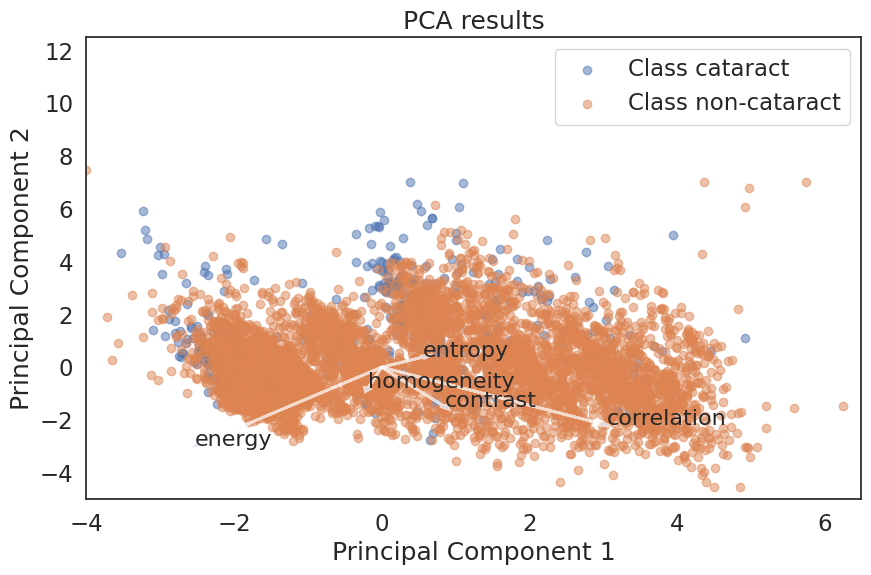

In [ ]:
# Separate features and target class
X = textures.drop('class', axis=1)
y = textures['class']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#PCA

pca = PCA(n_components=4)  # You can adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

principal_components = pca.components_

# Create a DataFrame to store the loadings
loadings_df = pd.DataFrame(principal_components, columns=['Loading_PC1', 'Loading_PC2', 'Loading_PC3', 'Loading_PC4'], index=['contrast', 'energy', 'homogeneity', 'entropy'])


print("Principal Components:")
print(principal_components)

#df = pd.DataFrame()

textures['PCA1'] = X_pca[:, 0]
textures['PCA2'] = X_pca[:, 1]
textures['PCA3'] = X_pca[:, 2]
textures['PCA4'] = X_pca[:, 3]

plt.figure(figsize=(10, 6))

for class_label in textures['class'].unique():
    class_data = textures[textures['class'] == class_label]
    plt.scatter(class_data['PCA1'], class_data['PCA2'], label=f'Class {class_label}' , alpha=0.5)

# Plot arrows for variable loadings
for i, feature in enumerate(loadings_df.index):
    plt.arrow(0, 0, loadings_df['Loading_PC1'][i]*4, loadings_df['Loading_PC2'][i]*4, alpha=0.7, linewidth=2, head_width=0.1)
    plt.text(loadings_df['Loading_PC1'][i] * 4.1, loadings_df['Loading_PC2'][i] * 4.1, feature, fontsize=16)

plt.title('PCA results')
plt.xlim([-4, 6.5])
plt.ylim([-5, 12.5])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

By plotting the cataract vs non-cataract data, we see that the clusters are not well-separeted: thus we thought of applying some contrast and brightness modifications (see the sections *Images preprocessing and dataset creation, Definition of the customized CNN model, Definition of EfficientNet based model*).

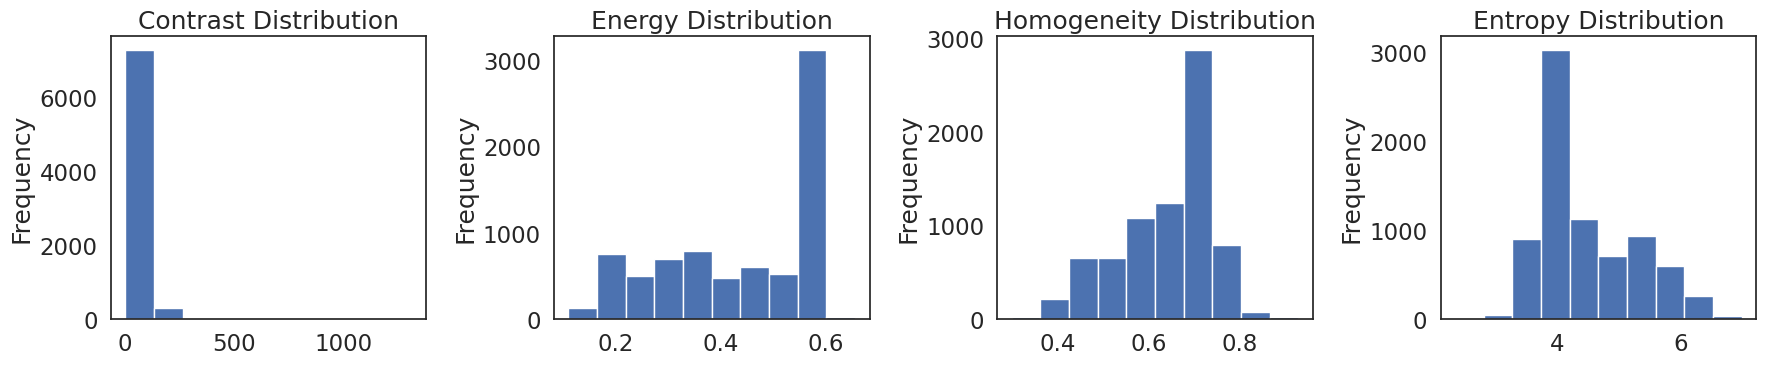

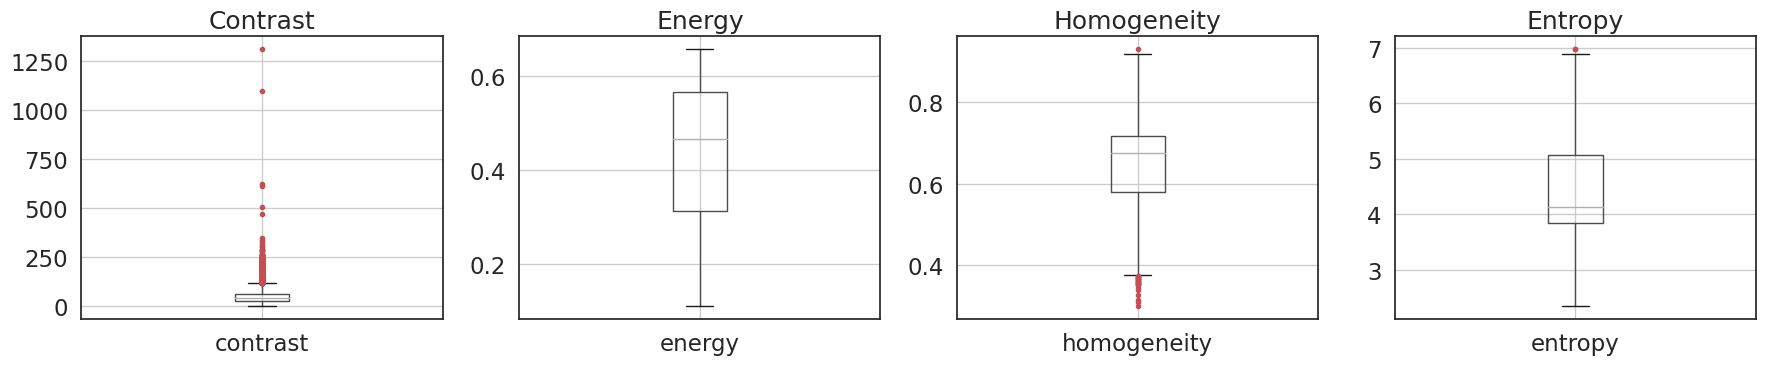

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

# Plotting distributions for each column
textures['contrast'].plot(kind='hist', ax=axes[0], title='Contrast Distribution')
textures['energy'].plot(kind='hist', ax=axes[1], title='Energy Distribution')
textures['homogeneity'].plot(kind='hist', ax=axes[2], title='Homogeneity Distribution')
textures['entropy'].plot(kind='hist', ax=axes[3], title='Entropy Distribution')


# Adjust layout
plt.tight_layout()
plt.show()


# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

# Plot boxplots for each variable
textures.boxplot(column='contrast', ax=axes[0], sym='r.')
axes[0].set_title('Contrast')

textures.boxplot(column='energy', ax=axes[1], sym='r.')
axes[1].set_title('Energy')

textures.boxplot(column='homogeneity', ax=axes[2], sym='r.')
axes[2].set_title('Homogeneity')

textures.boxplot(column='entropy', ax=axes[3], sym='r.')
axes[3].set_title('Entropy')

# Adjust layout
plt.tight_layout()
plt.show()

The only feature with a fairly large amount of outliers is contrast; this confirms that contrast and brightness modifications are needed.

# Images preprocessing and dataset creation

In the original project, no imaging preprocessing was performed other than resizing, although preprocessing is a crucial step in developing a CNN.

In the original dataset, all the images were rectangular and with different dimensions, but we are interested only in the circle of the ocular fundus images.

To solve this problem we found [some code](https://github.com/linchundan88/Fundus-image-preprocessing/blob/master/fundus_preprocessing.py) that can extract the circular shape present in fundus images and then resize the image with a square aspect ratio.

In [29]:
# Github code

DEL_PADDING_RATIO = 0.02  # used for del_black_or_white
CROP_PADDING_RATIO = 0.02  # used for my_crop_xyr

# del_black_or_white margin
THRESHOLD_LOW = 7
THRESHOLD_HIGH = 180

# HoughCircles
MIN_RADIUS_RATIO = 0.33
MAX_RADIUS_RATIO = 0.6

#------------------------------------------------------------------------------------------------------

# The function 'del_black_or_white' crops the black and white margins of an image
# according to the provided parameters

def del_black_or_white(img1):
    if img1.ndim == 2:
        img1 = np.expand_dims(img1, axis=-1)

    width, height = (img1.shape[1], img1.shape[0])

    (left, bottom) = (0, 0)
    (right, top) = (img1.shape[1], img1.shape[0])

    padding = int(min(width, height) * DEL_PADDING_RATIO)

    # Look for the inferior limit

    for i in range(width):
        array1 = img1[:, i, :]
        if np.sum(array1) > THRESHOLD_LOW * array1.shape[0] * array1.shape[1] and \
                np.sum(array1) < THRESHOLD_HIGH * array1.shape[0] * array1.shape[1]:
            left = i
            break
    left = max(0, left-padding)

    # Look for the superior limit

    for i in range(width - 1, 0 - 1, -1):
        array1 = img1[:, i, :]
        if np.sum(array1) > THRESHOLD_LOW * array1.shape[0] * array1.shape[1] and \
                np.sum(array1) < THRESHOLD_HIGH * array1.shape[0] * array1.shape[1]:
            right = i
            break
    right = min(width, right + padding)

    # Look for the left limit

    for i in range(height):
        array1 = img1[i, :, :]
        if np.sum(array1) > THRESHOLD_LOW * array1.shape[0] * array1.shape[1] and \
                np.sum(array1) < THRESHOLD_HIGH * array1.shape[0] * array1.shape[1]:
            bottom = i
            break
    bottom = max(0, bottom - padding)

    # Look for the right limit

    for i in range(height - 1, 0 - 1, -1):
        array1 = img1[i, :, :]
        if np.sum(array1) > THRESHOLD_LOW * array1.shape[0] * array1.shape[1] and \
                np.sum(array1) < THRESHOLD_HIGH * array1.shape[0] * array1.shape[1]:
            top = i
            break
    top = min(height, top + padding)

    img2 = img1[bottom:top, left:right, :]

    return img2

#------------------------------------------------------------------------------------------------------

# 'detect_xyr' detects the circle in the images using the Hough transform on grayscale images

def detect_xyr(img_source):
    if isinstance(img_source, str):
        try:
            img = cv2.imread(img_source)
        except:
            # Corrupt JPEG data1: 19 extraneous bytes before marker 0xc4
            raise Exception("image file not found:" + img_source)
        if img is None:
            raise Exception("image file error:" + img_source)
    else:
        img = img_source


    width = img.shape[1]
    height = img.shape[0]

    myMinWidthHeight = min(width, height)

    myMinRadius = round(myMinWidthHeight * MIN_RADIUS_RATIO)
    myMaxRadius = round(myMinWidthHeight * MAX_RADIUS_RATIO)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, minDist=450, param1=120, param2=32,
                               minRadius=myMinRadius,
                               maxRadius=myMaxRadius)

    (x, y, r) = (0, 0, 0)
    found_circle = False

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        if (circles is not None) and (len(circles == 1)):

            x1, y1, r1 = circles[0]
            if x1 > (2 / 5 * width) and x1 < (3 / 5 * width) \
                    and y1 > (2 / 5 * height) and y1 < (3 / 5 * height):
                x, y, r = circles[0]
                found_circle = True

    if not found_circle:
        # suppose the center of the image is the center of the circle
        x = img.shape[1] // 2
        y = img.shape[0] // 2

        # get radius  according to the distribution of pixels of the middle line
        temp_x = img[int(img.shape[0] / 2), :, :].sum(1)
        r = int((temp_x > temp_x.mean() / 12).sum() / 2)

    return (found_circle, x, y, r)

#------------------------------------------------------------------------------------------------------

# 'my_crop_xyr' crops the images based on the parameters found using the function above

def my_crop_xyr(img_source, x, y, r, crop_size=None):
    if isinstance(img_source, str):
        # img_source is a file name
        try:
            image1 = cv2.imread(img_source)
        except:
            # Corrupt JPEG data1: 19 extraneous bytes before marker 0xc4
            raise Exception("image file not found:" + img_source)
    else:
        image1 = img_source

    if image1 is None:
        raise Exception("image file error:" + img_source)

    original_width = image1.shape[1]
    original_height = image1.shape[0]

    (image_height, image_width) = (image1.shape[0], image1.shape[1])

    img_padding = int(min(original_width, original_height) * CROP_PADDING_RATIO)

    image_left = int(max(0, x - r - img_padding))
    image_right = int(min(x + r + img_padding, image_width - 1))
    image_bottom = int(max(0, y - r - img_padding))
    image_top = int(min(y + r + img_padding, image_height - 1))

    if image_width >= image_height:
        if image_height >= 2 * (r + img_padding):
            image1 = image1[image_bottom: image_top, image_left:image_right]
        else:
            image1 = image1[:, image_left:image_right]
    else:
        if image_width >= 2 * (r + img_padding):
            image1 = image1[image_bottom: image_top, image_left:image_right]
        else:
            image1 = image1[image_bottom:image_top, :]

    if crop_size is not None:
        image1 = cv2.resize(image1, (crop_size, crop_size))

    return image1

#------------------------------------------------------------------------------------------------------

# 'add_black_margin' adds black margins to avoid losing information in case of data augmentation

def add_black_margin(img_source, add_black_pixel_ratio = 0.05):
    if isinstance(img_source, str):
        # img_source is a file name
        try:
            image1 = cv2.imread(img_source)
        except:
            # Corrupt JPEG data1: 19 extraneous bytes before marker 0xc4
            raise Exception("image file not found:" + img_source)
    else:
        image1 = img_source

    if image1 is None:
        raise Exception("image file error:" + img_source)

    height, width = image1.shape[:2]

    add_black_pixel = int(min(height, width) * add_black_pixel_ratio)

    img_h = np.zeros((add_black_pixel, width, 3))
    img_v = np.zeros((height + add_black_pixel*2, add_black_pixel, 3))

    image1 = np.concatenate((img_h, image1, img_h), axis=0)
    image1 = np.concatenate((img_v, image1, img_v), axis=1)

    return image1


The following pipeline is implemented using functions defined above:
1.  Input image is read from the provided path
2.  Removal of black/white margins
3.  Detection of ocular fundus circle using the Hough transform
4.  Conversion to RGB
5.  Cropping of the images using parameters found before
6.  Addition of black margins to avoid losing information in case of data augmentation



In [30]:
# Also from Github
def my_preprocess(img_source, crop_size, train_or_valid='train'):
    if isinstance(img_source, str):
        try:
            image1 = cv2.imread(img_source)
        except:
            # Corrupt JPEG data1: 19 extraneous bytes before marker 0xc4
            raise Exception("image file not found:" + img_source)
    else:
        image1 = img_source

    if image1 is None:  # file not exists or orther errors
        raise Exception("image file error:" + img_source)

    image1 = del_black_or_white(image1)

    min_width_height = min(image1.shape[0], image1.shape[1])

    if min_width_height < 100: # image too small
        return None

    # image too big, resize
    image_size_before_hough = crop_size * 2
    if min_width_height > image_size_before_hough:
        crop_ratio = image_size_before_hough / min_width_height
        # fx, fy: Scaling factor  x axis and y axis
        image1 = cv2.resize(image1, None, fx=crop_ratio, fy=crop_ratio)

    (found_circle, x, y, r) = detect_xyr(image1)

    if train_or_valid == 'train':
        image1 = my_crop_xyr(image1, x, y, r)
        image1 = add_black_margin(image1, add_black_pixel_ratio=0.07)
        image1 = cv2.resize(image1, (crop_size, crop_size))
    else:
        image1 = my_crop_xyr(image1, x, y, r, crop_size)

    return image1

In this section, datasets are created.
The image preprocessing steps applied are:
1. `my_preprocess` (previously described)
2. Conversion to grayscale
3. CLAHE
4. Median filtering
5. Resizing

After trying different preprocessing pipelines, this one produced the best result.
Only the labels are kept from the original dataframe.

The choice of using CLAHE was aided by the results of exploratory data analysis.
Median filtering simply yielded better results.

In the original project, one hot encoding for the diagnosis was performed in order to use categorical cross-entropy as a loss function in the model. Instead, we decided to use binary cross-entropy, because we are discerning beetwen eyes with and without cataract. Also, only the last two steps were performed, thus images were RGB.




In [31]:
def create_datasets(df, img_width, img_height):

    imgs = []
    for fname in tqdm(df['paths']):
        img = cv2.imread(fname)

        img = my_preprocess(img, crop_size=384)

        # Check if the image has a 64-bit float depth
        if img.dtype == np.float64:
           img = cv2.convertScaleAbs(img)

        # CLAHE applied to the grayscale image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
        img = clahe.apply(img)

        # Median filter
        img = ndimage.median_filter(img, size=3)

        # Resizing
        img = cv2.resize(img, (img_width, img_height))

        imgs.append(img)

    imgs = np.array(imgs, dtype='float32')

    # Keeping only labels
    df= df['cataract']

    return imgs, df

Preprocessing is applied to all sets:

In [32]:
train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

# Scaling
train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|██████████| 312/312 [00:44<00:00,  7.04it/s]


## Results

The following is a plot of the images after the preprocessing.

In the original project two plots analogous to this one were present, one for training set data and one for test set data. We also noticed that all the non-cataract images were displayed as 'Normal', even though among them there were also non-healthy eyes.

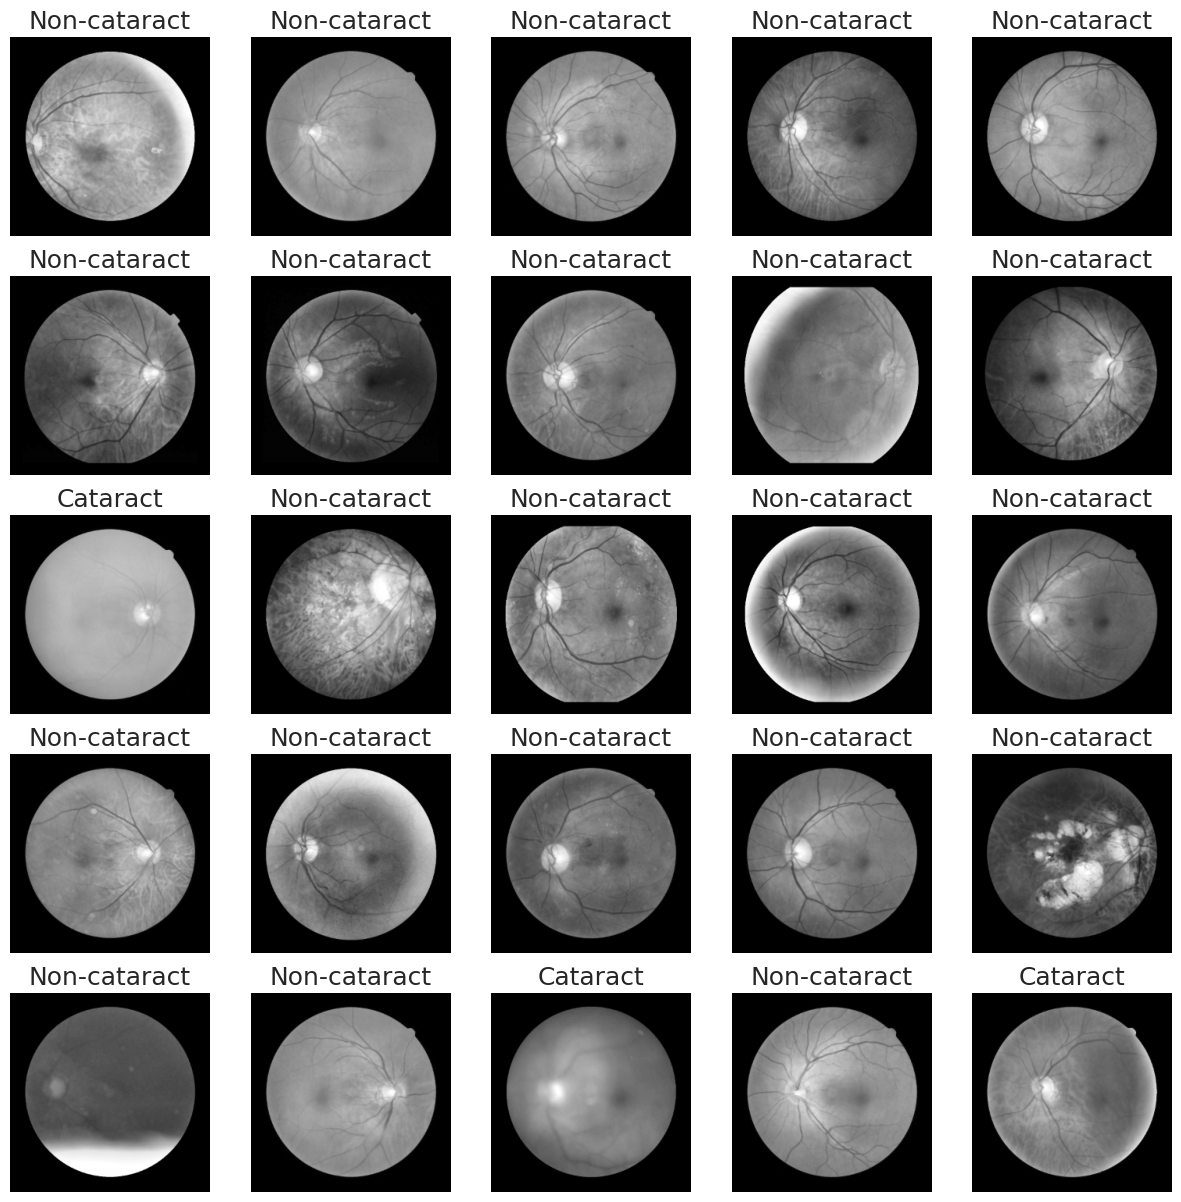

In [33]:
# plot of 25 sheets of images

f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[10:35])
for i, img in enumerate(train_imgs[10:35]):
    ax[i//5, i%5].imshow(img, 'gray')
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('Cataract')
    else:
        ax[i//5, i%5].set_title('Non-cataract')
plt.show()

# Definiton of the customized CNN model

## Original Kaggle model
The original model is composed of two blocks, each on one with:
* Two convolutional layers, using `mish` as an activation function
* Batch normalization
* One maxpooling layer
* Dropout

The final part of the architecture is composed by:
* Flattening layer
* Dense layer with `softmax` as activation function

The model compiler uses `Adam` as optimizer and `categorical_cossentropy` as loss function.

In [34]:
# input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

# model = Sequential()

# model.add(Conv2D(16, kernel_size=3, padding='same',
#                  input_shape=input_shape, activation='mish'))
# model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(3))
# model.add(Dropout(0.3))

# model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
# model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(3))
# model.add(Dropout(0.3))

# model.add(Flatten())
# model.add(Dense(2, activation='softmax'))

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

These are the original results from Kaggle:

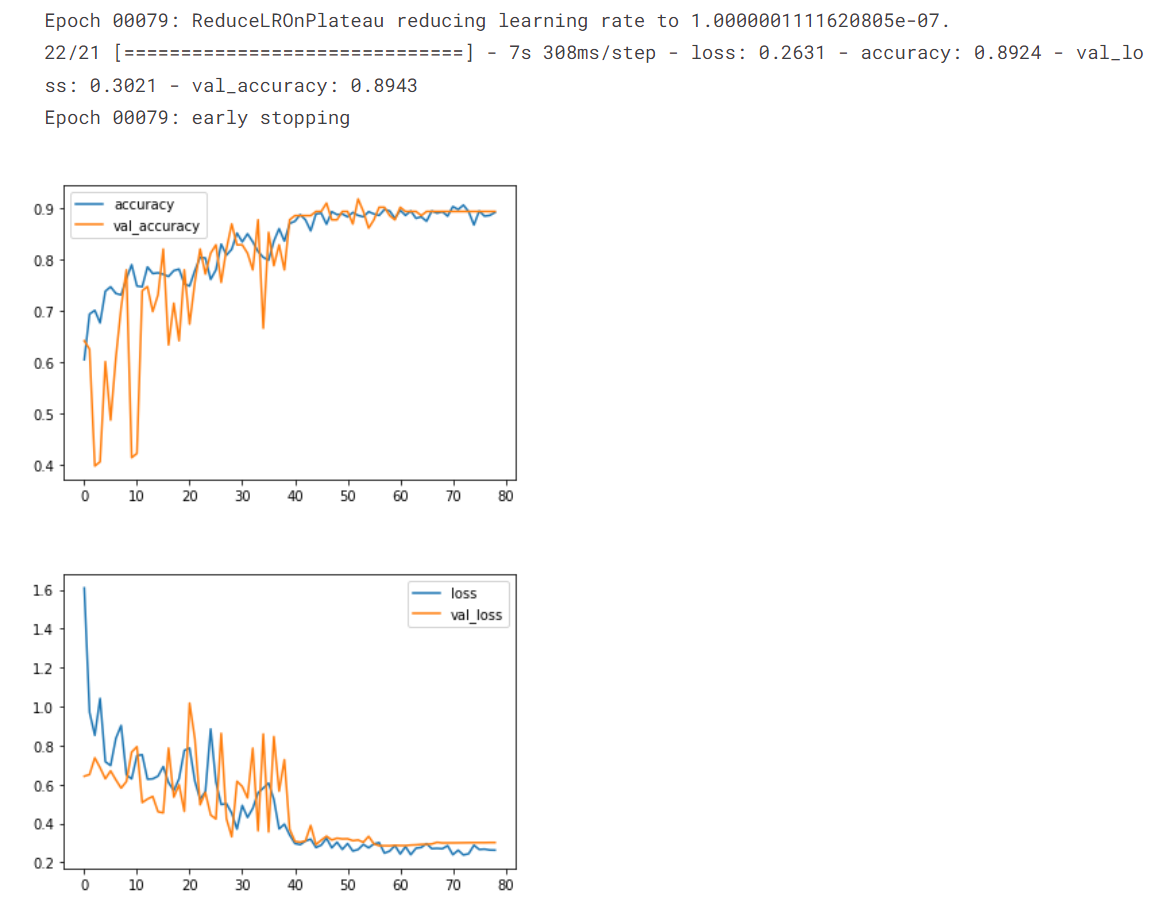

And these are the results on the test set:

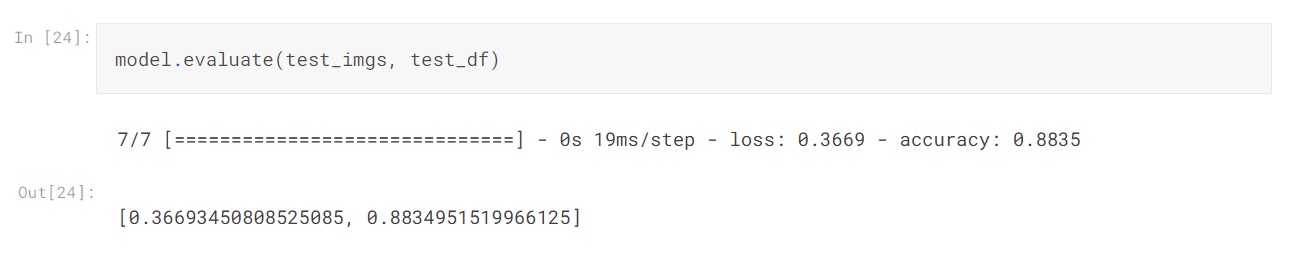

## Group project version

Compared with the original architecture, we played with:
* Activation function: we chose `ReLU` rather than `Mish`, as we have often seen in laboratories
* `binary_crossentropy` as loss function, instead of `categorical_crossentropy`
* Hyperparameters
* Last layer: we adapted it to match the use of binary cross-entropy, and in particular we use the `sigmoid` instead of the `softmax`
* `ImageDataGenerator` (deprecated) was replaced, speeding up the training phase by several minutes. The keras layers `RandomFlip`, `RandomZoom` and `RandomContrast` (the latter missing in the original model) are used instead.

The final architecture is as follows:


In [35]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)

model = Sequential()

# Data augmentation
model.add(RandomFlip(mode='horizontal', input_shape=input_shape, seed = SEED))
model.add(RandomZoom(0.1, fill_mode = 'reflect', seed = SEED))
model.add(RandomContrast(0.1, seed = SEED)) # missing in original model

# Convolutional layers
# First convolutional layer
model.add(Conv2D(16, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPool2D(3))
# Second convolutional layer
model.add(Conv2D(16, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPool2D(3))
# Third convolutional layer
model.add(Conv2D(32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPool2D(3))
# Fourth convolutional layer
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(3))
model.add(Dropout(0.3))

# Flatten
model.add(Flatten())
# Fully Connected Layers
# Dense 1
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
# Dense 2
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 256, 256, 1)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 1)       0         
                                                                 
 random_contrast (RandomCon  (None, 256, 256, 1)       0         
 trast)                                                          
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      800       
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 16)        6

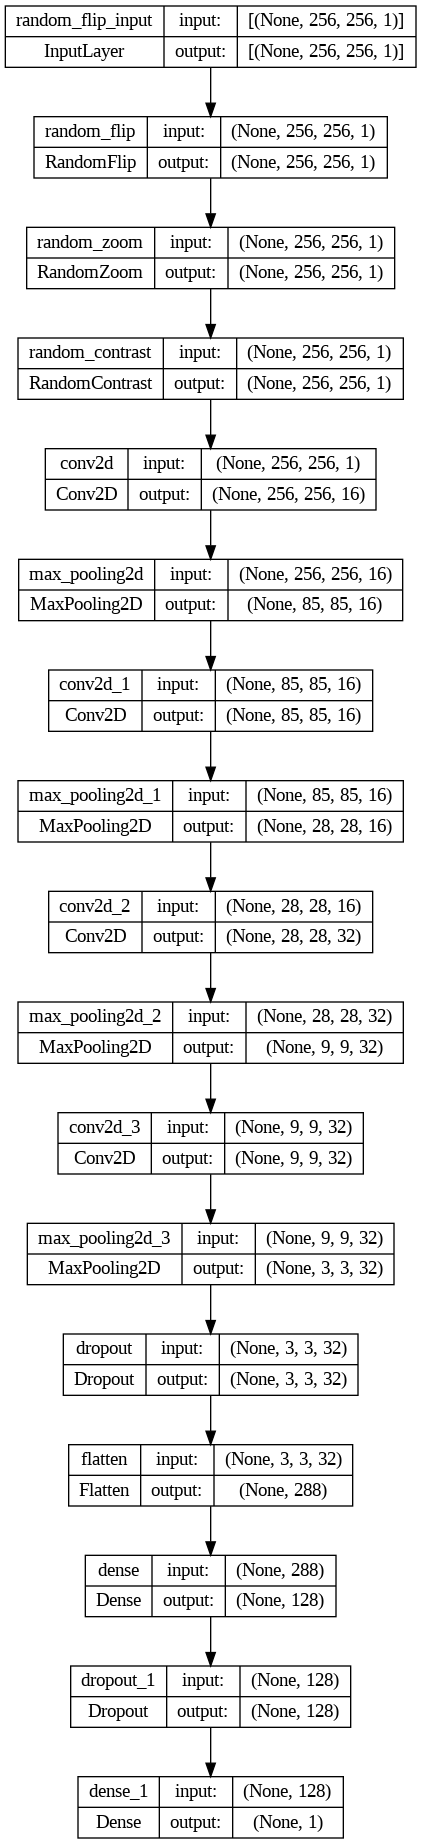

In [36]:
tf.keras.utils.plot_model(model, show_shapes=True)

Definition of callbacks:
* the `EarlyStopping` `patience` criterion defines the number of epochs with no improvements after which training will be stopped
* the `patience` criterion in the `ReduceLROnPlateau` defines the number of epochs with no improvements after which the learning rate is reduced by a factor `factor`

In [37]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=20,
                                               verbose=1,
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Since we have a limited number of cataract images but we want to use as many images as possible, we use the function `compute_class_weight` to compute class weights that will account during model training for class imbalance.

In [38]:
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_df),
                                        y = train_df
                                    )

class_weights = dict(zip(np.unique(train_df), class_weights))

Training the model:

Epoch 1/100
32/32 [==============================] - 11s 92ms/step - loss: 0.6926 - accuracy: 0.5149 - val_loss: 0.6777 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 1s 35ms/step - loss: 0.6772 - accuracy: 0.6050 - val_loss: 0.7003 - val_accuracy: 0.4486 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 1s 34ms/step - loss: 0.6497 - accuracy: 0.6222 - val_loss: 0.6237 - val_accuracy: 0.7135 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 1s 33ms/step - loss: 0.5974 - accuracy: 0.7057 - val_loss: 0.4540 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 1s 33ms/step - loss: 0.5527 - accuracy: 0.7546 - val_loss: 0.4642 - val_accuracy: 0.7892 - lr: 0.0010
Epoch 6/100
32/32 [==============================] - 1s 33ms/step - loss: 0.5484 - accuracy: 0.7613 - val_loss: 0.5189 - val_accuracy: 0.7946 - lr: 0.0010
Epoch 7/100
32/32 [==============================] - 1s 33ms/step - l

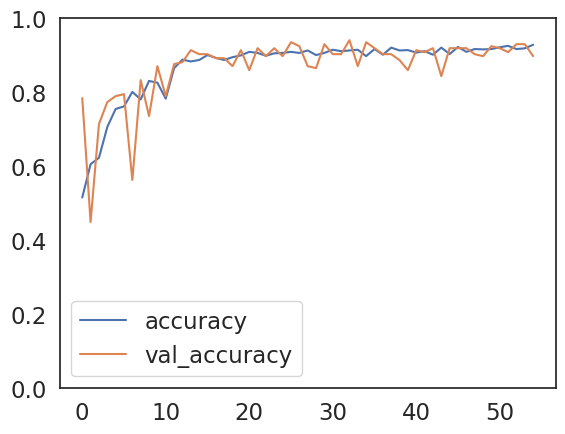

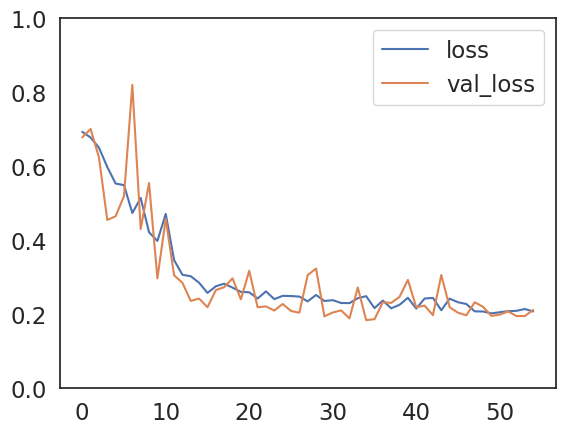

In [39]:
# Model training
history = model.fit(train_imgs, train_df,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    steps_per_epoch= len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df),
                    class_weight=class_weights)


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
ax = plt.gca()
ax.set_ylim(0, 1)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
ax = plt.gca()
ax.set_ylim(0, 1)
plt.show()

### Results




In [40]:
# Evaluating the model on test set
print('Test values')
model.evaluate(test_imgs, test_df)

Test values
10/10 [==============================] - 0s 50ms/step - loss: 0.1867 - accuracy: 0.9423


[0.18668226897716522, 0.942307710647583]

We compute the confusion matrix:

10/10 [==============================] - 0s 8ms/step


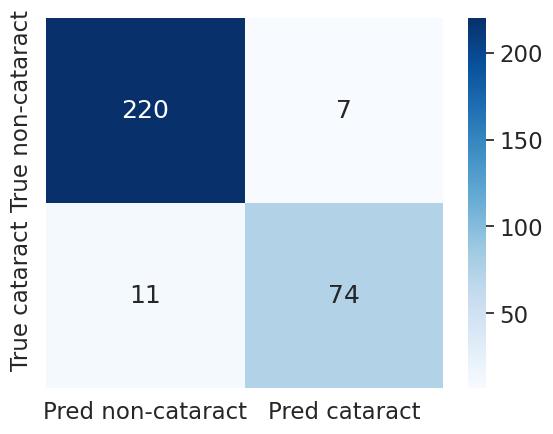

In [41]:
# Getting image = cataract probabilities
test_prob = model.predict(test_imgs)

# Confusion matrix
cm = confusion_matrix(test_df, (test_prob > 0.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred non-cataract", "Pred cataract"], yticklabels=["True non-cataract", "True cataract"])
tn, fp, fn, tp = confusion_matrix(test_df, (test_prob>0.5)).ravel()

We evaluate the performance of our model using more metrics than only accuracy as it was done in the original model.

In [42]:
accuracy = accuracy_score(test_df, (test_prob > 0.5))
precision = precision_score(test_df, (test_prob > 0.5))
f1 = f1_score(test_df, (test_prob > 0.5))
balanced_accuracy = balanced_accuracy_score(test_df, (test_prob > 0.5))
roc_curve(test_df, (test_prob > 0.5))
auc = roc_auc_score(test_df, (test_prob > 0.5))
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("F1 Score:", round(f1, 3))
print("Balanced accuracy:", round(balanced_accuracy, 3))
print("ROC AUC:", round(auc, 3))
print("Sensitivity:", round(sensitivity, 3))
print("Specificity:", round(specificity, 3))


Accuracy: 0.942
Precision: 0.914
F1 Score: 0.892
Balanced accuracy: 0.92
ROC AUC: 0.92
Sensitivity: 0.871
Specificity: 0.969


Although the accuracy is not the best parameter to evaluate the model performance because of class imbalance, the results obtained are positive, and the other metrics we used comfirm this impression.

Possible applications of a model like the one we presented lead us to think that diagnosing non-cataract patients as having cataracts (in a preliminary phase) is better than the opposite option.

Therefore we tried to vary the classification threshold to minimimize false negatives, while still keeping an eye on TPR/TNR balance.

In [43]:
# Computing FPR & TPR for several possible thresholds
fpr, tpr, thresholds = roc_curve(test_df, test_prob)
# Computing FNR & TNR
fnr = fp/(fp+tn)
tnr = 1-fpr

i = np.arange(len(tpr))
# Find the threshold for which TPR & TNR are most similar (TPR-TNR~0)
roc = pd.DataFrame({'tf': pd.Series(tpr-(1-fpr), index=i), 'thresholds': pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
print('Ideal threshold: ', round(float(ideal_roc_thresh['thresholds']),3))

Ideal threshold:  0.329


To reduce FN we apply a threshold 10% smaller than the ideal one:

In [44]:
adj_threshold = float(list(ideal_roc_thresh['thresholds'])-0.1*ideal_roc_thresh['thresholds'])
print('Adjusted threshold: ', round(adj_threshold,3))

Adjusted threshold:  0.296


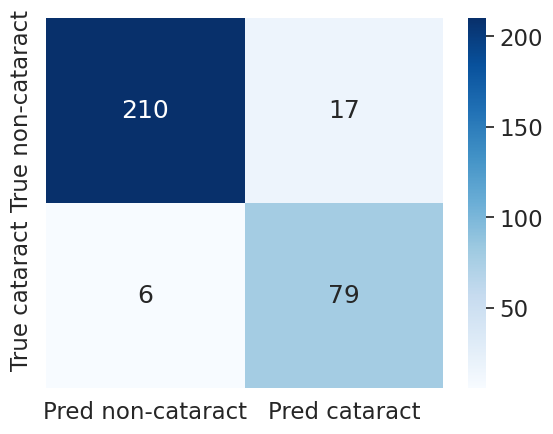

In [45]:
# Confusion matrix with adjusted threshold
cm = confusion_matrix(test_df, (test_prob > adj_threshold ))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred non-cataract", "Pred cataract"], yticklabels=["True non-cataract", "True cataract"])
tn, fp, fn, tp = confusion_matrix(test_df, (test_prob> adj_threshold)).ravel()

In [46]:
# Metrics with adjusted threshold
accuracy2 = accuracy_score(test_df, (test_prob > adj_threshold))
precision2 = precision_score(test_df, (test_prob > adj_threshold))
f12 = f1_score(test_df, (test_prob > adj_threshold))
balanced_accuracy2 = balanced_accuracy_score(test_df, (test_prob > adj_threshold))
roc_curve(test_df, (test_prob > adj_threshold))
auc2 = roc_auc_score(test_df, (test_prob > adj_threshold))
sensitivity2 = tp/(tp+fn)
specificity2 = tn/(fp+tn)

print("Accuracy:", round(accuracy2, 3))
print("Precision:", round(precision2, 3))
print("F1 Score:", round(f12, 3))
print("Balanced accuracy:", round(balanced_accuracy2, 3))
print("ROC AUC:", round(auc2, 3))
print("Sensitivity:", round(sensitivity2, 3))
print("Specificity:", round(specificity2, 3))

Accuracy: 0.926
Precision: 0.823
F1 Score: 0.873
Balanced accuracy: 0.927
ROC AUC: 0.927
Sensitivity: 0.929
Specificity: 0.925


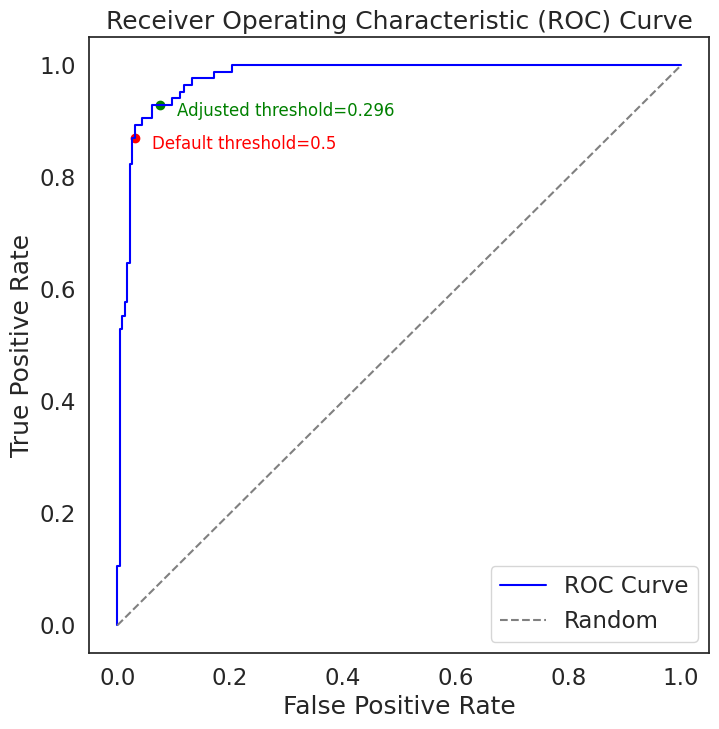

In [47]:
# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')
plt.scatter(1-specificity, sensitivity, color='red')
plt.text((1-specificity+0.03), sensitivity-0.02, 'Default threshold=0.5' , fontsize=12, color='red')
plt.text((1-specificity2+0.03), sensitivity2-0.02, 'Adjusted threshold='+ str(round(adj_threshold,3)), fontsize=12, color='green')
plt.scatter(1-specificity2, sensitivity2, color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Definition of EfficientNet based model

## Original Kaggle model



In [48]:
# def build_model(img_height, img_width, n):
#     inp = Input(shape=(img_height,img_width,n))
#     efnet = efn.EfficientNetB0(
#         input_shape=(img_height,img_width,n),
#         weights='imagenet',
#         include_top=False
#     )
#     x = efnet(inp)
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(2, activation='softmax')(x)
#     model = tf.keras.Model(inputs=inp, outputs=x)
#     opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
#     loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
#     model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
#     return model

# model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)

The results of the original model, reported above, are as follows:

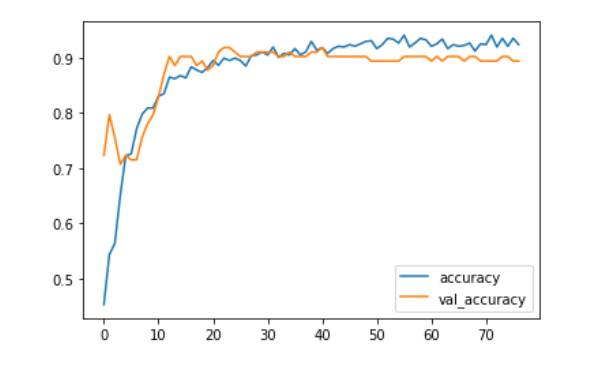

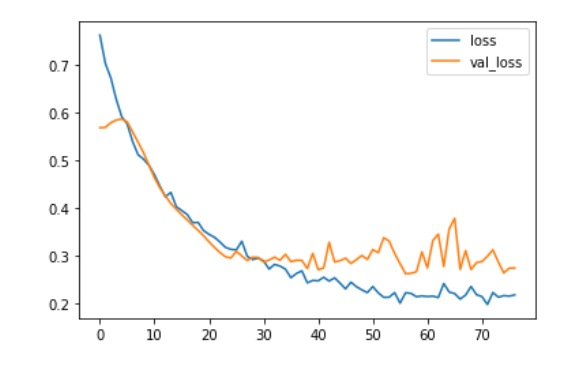

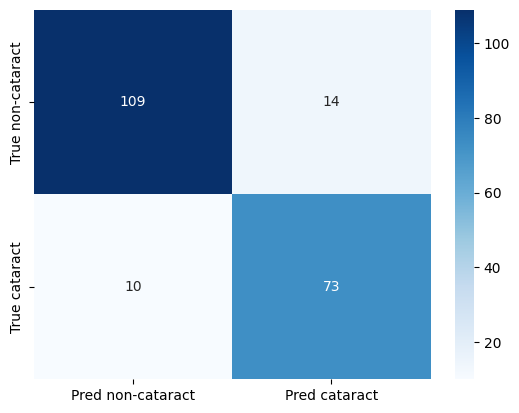

##  Group project version

For the second model a pre-trained CNN called EfficientNet B0 has been used. The last layer is not included in order to adapt it to our scenario.

With respect to the original model, we replace data augmentation performed by `ImageDataGenerator` with a custom combination of Keras layers.
In the original model, EffNet's weights weren't freezed, so they were updated during training; we freeze the weights and add a Dense and a Dropout layer.
The only trainable parameters are the ones that characterize the Dense layers, as we can see from the output of the cells below.

The Efficientnet B0 documentation suggests using images with size 224x224 pixels, with 3 color channels. In the original code, the images used had a rectangular shape (256x192 px) and were RGB. We resize the images and triplicate the color channel, because after the preprocessing steps they are in grayscale.

Since we decided to use Binary Cross-entropy as a loss function, we adapt the last Dense layer to accomodate that (i.e. we replace the `softmax` function with `sigmoid`).

In [49]:
# EffNet expects images with 3 channels
train_imgs_3ch = np.repeat(train_imgs[..., np.newaxis], 3, -1)
test_imgs_3ch = np.repeat(test_imgs[..., np.newaxis], 3, -1)
val_imgs_3ch = np.repeat(val_imgs[..., np.newaxis], 3, -1)

# EffNetB0 expects 224 x 224 px images
size = (224, 224)

def efnet_resize(array):
  array_efn = []
  for img in array:
      # Resizing
      img_224 = cv2.resize(img, size)
      array_efn.append(img_224)
  array_efn = np.array(array_efn, dtype='float32')

  return array_efn

# Resizing the sets
train_imgs_efnet = efnet_resize(train_imgs_3ch)
test_imgs_efnet = efnet_resize(test_imgs_3ch)
val_imgs_efnet = efnet_resize(val_imgs_3ch)

In [50]:
input_shape = (224, 224, 3)

# Custom data augmentation routine
data_augmentation = Sequential(
    [
      RandomFlip(mode='horizontal', input_shape=input_shape, seed = SEED),
      RandomZoom(0.1, fill_mode = 'reflect', seed = SEED),
      RandomContrast(0.2, seed = SEED),
    ]
)

def build_model(img_height, img_width, n):

    inp = Input(shape=(img_height, img_width, n))
    efnet = efn.EfficientNetB0(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False,)
    # Freezing the model
    efnet.trainable=False

    # Data augmentation
    x = data_augmentation(inp)

    # EffNetb0
    x = efnet(x)

    x = GlobalAveragePooling2D()(x)

    # Additional layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Adapting the layer to our problem
    x = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model = build_model(224, 224, 3)
model.summary()

16804768/16804768 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnet-b0 (Functiona  (None, 7, 7, 1280)        4049564   
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                              

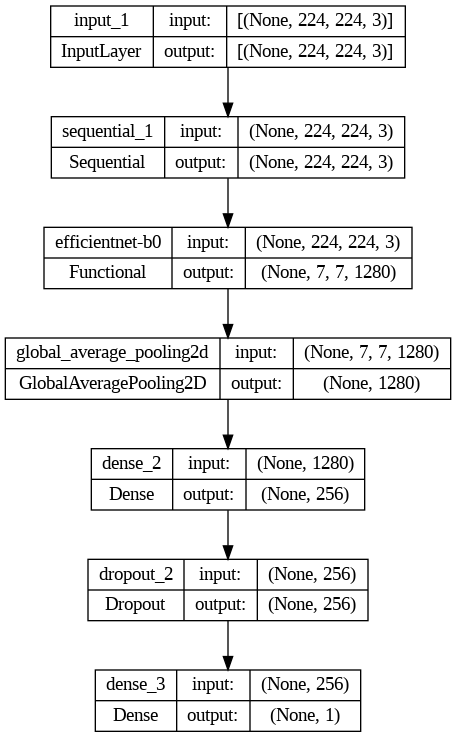

In [51]:
tf.keras.utils.plot_model(model, show_shapes=True)

The model is then trained; we pass `class_weigths` to the model, as we did before, in order to take into account class imbalance.

Epoch 1/100
32/32 [==============================] - 16s 287ms/step - loss: 0.7257 - accuracy: 0.4113 - val_loss: 0.7076 - val_accuracy: 0.4865 - lr: 3.0000e-06
Epoch 2/100
32/32 [==============================] - 3s 90ms/step - loss: 0.6952 - accuracy: 0.4794 - val_loss: 0.6609 - val_accuracy: 0.6811 - lr: 3.0000e-06
Epoch 3/100
32/32 [==============================] - 3s 80ms/step - loss: 0.6608 - accuracy: 0.5676 - val_loss: 0.6244 - val_accuracy: 0.7784 - lr: 3.0000e-06
Epoch 4/100
32/32 [==============================] - 3s 90ms/step - loss: 0.6431 - accuracy: 0.5849 - val_loss: 0.5906 - val_accuracy: 0.8486 - lr: 3.0000e-06
Epoch 5/100
32/32 [==============================] - 3s 90ms/step - loss: 0.6195 - accuracy: 0.6491 - val_loss: 0.5612 - val_accuracy: 0.8703 - lr: 3.0000e-06
Epoch 6/100
32/32 [==============================] - 3s 86ms/step - loss: 0.5991 - accuracy: 0.6826 - val_loss: 0.5378 - val_accuracy: 0.8973 - lr: 3.0000e-06
Epoch 7/100
32/32 [=========================

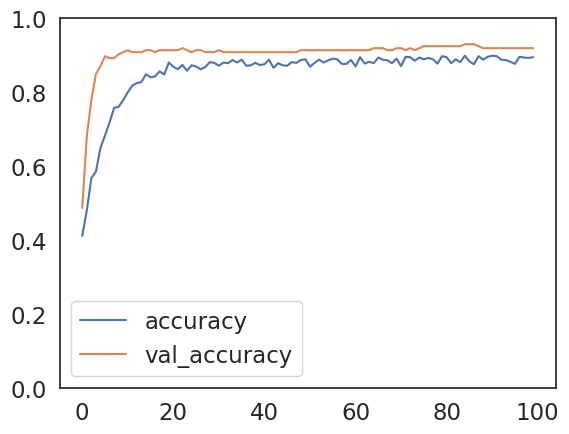

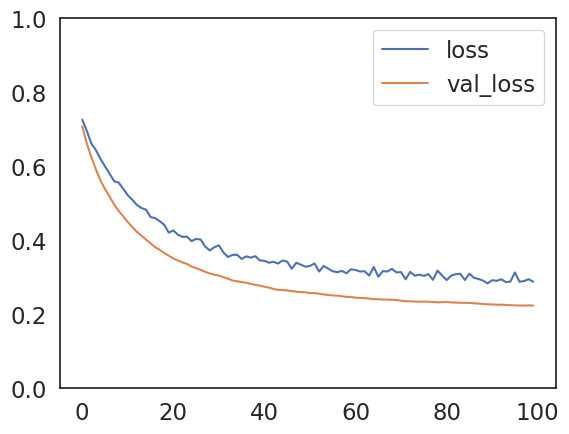

In [52]:
# Training the model
history = model.fit(train_imgs_efnet, train_df,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs_efnet, val_df),
                    class_weight=class_weights)

# Checking performance
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
ax = plt.gca()
ax.set_ylim(0, 1)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
ax = plt.gca()
ax.set_ylim(0, 1)
plt.show()

### Results




In [53]:
# Evaluating the model on test set
print('Test values')
model.evaluate(test_imgs_efnet, test_df)

Test values
10/10 [==============================] - 2s 197ms/step - loss: 0.2248 - accuracy: 0.9295


[0.2247709184885025, 0.9294871687889099]

We compute the confusion matrix:

10/10 [==============================] - 2s 60ms/step


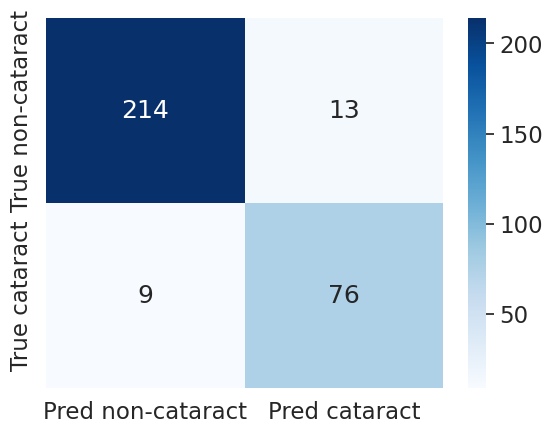

In [54]:
# Getting image = cataract probabilities
test_prob = model.predict(test_imgs_efnet)

# Confusion matrix
cm = confusion_matrix(test_df, (test_prob > 0.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred non-cataract", "Pred cataract"], yticklabels=["True non-cataract", "True cataract"])
tn, fp, fn, tp = confusion_matrix(test_df, (test_prob>0.5)).ravel()

We evaluate the performance of our model using more metrics than only accuracy as it was done in the original model.

In [55]:
accuracy = accuracy_score(test_df, (test_prob > 0.5))
precision = precision_score(test_df, (test_prob > 0.5))
f1 = f1_score(test_df, (test_prob > 0.5))
balanced_accuracy = balanced_accuracy_score(test_df, (test_prob > 0.5))
roc_curve(test_df, (test_prob > 0.5))
auc = roc_auc_score(test_df, (test_prob > 0.5))
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("F1 Score:", round(f1, 3))
print("Balanced accuracy:", round(balanced_accuracy, 3))
print("ROC AUC:", round(auc, 3))
print("Sensitivity:", round(sensitivity, 3))
print("Specificity:", round(specificity, 3))


Accuracy: 0.929
Precision: 0.854
F1 Score: 0.874
Balanced accuracy: 0.918
ROC AUC: 0.918
Sensitivity: 0.894
Specificity: 0.943


Although the accuracy is not the best parameter to evaluate the model performance because of class imbalance, the results obtained are positive, and the other metrics we used comfirm this impression.

# Conclusion

Overall, we overcame the original project limitations and developed a more cohesive code structure.
While we think that our models performance is good, we realize that some improvements are needed and performance is not optimal (as shown by the confusion matrix), possibly due to the high variety of diseases present in the datasets.
The problem would therefore benefit from a multiclass approach or from a more focused data selection.
Lastly, a higher quality dataset, possibly with more cataract images, would help.